In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# sepervised dimensionality reduction

#shift-tab on a function gets its docstring

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import lal
import lalsimulation

import pycbc.filter
#import pycbc.waveform
import pycbc.types
import pycbc.psd

__init__: Setting weave cache to /var/folders/zl/bw0yy2l15g339xpfq2gmxh7c0000gn/T/501_python27_compiled/1.6.2/


In [3]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [26]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# functions for constructing surrogate

In [6]:
def geometric_waveform_to_physical_hp_hc(h_geom, mtot, distance, inclination, f_min, f_max, delta_f):
    """Convert a frequency-domain Waveform object to ~h_+ and ~h_x in physical units (Hz^{-1})
    using the same convention as lalsimulation:
        -Uniformly spaced frequencies in [0, f_max).
        -Data is zero below max(f_min, first data point in h_geom) and
        zero above min(f_max, last data point in h_geom).
    """
    h_phys = wave.dimensionless_to_physical_freq(h_geom, mtot, distance)
    
    # Initialize arrays. The output is zero below f_min.
    freq = np.arange(0.0, f_max, delta_f)
    h_plus = np.zeros(len(freq), dtype=complex)
    h_cross = np.zeros(len(freq), dtype=complex)
    
    # Find the nonzero elements
    f_min_nonzero = max(f_min, h_phys.x[0])
    f_max_nonzero = min(f_max, h_phys.x[-1])
    # Can't compare arrays with 'and'. Have to use bitwise '&' instead.
    i_nonzero = np.where((freq>=f_min_nonzero) & (freq<=f_max_nonzero))
    freq_nonzero = freq[i_nonzero]
    
    # Amplitude and phase in the nonzero region
    amp = h_phys.interpolate('amp')(freq_nonzero)
    phase = h_phys.interpolate('phase')(freq_nonzero)
    
    inc_plus = 0.5*(1.0+np.cos(inclination)**2)
    inc_cross = np.cos(inclination)
    
    h_plus[i_nonzero] = inc_plus * 0.5*amp*np.exp(1.0j*phase)
    h_cross[i_nonzero] = inc_cross * 0.5*amp*np.exp(1.0j*(phase+np.pi/2.0))
    
    return freq, h_plus, h_cross

In [8]:
def physical_to_pycbc_frequency_series(freq, h_plus, h_cross):
    delta_f = freq[1]-freq[0]
    hp_fs = pycbc.types.FrequencySeries(h_plus, delta_f=delta_f)
    hc_fs = pycbc.types.FrequencySeries(h_cross, delta_f=delta_f)
    return hp_fs, hc_fs

In [46]:
class GPSurrogate(object):
    def __init__(self, Bamp, Bphase, damp_gp_list, dphase_gp_list):
        self.Bamp = Bamp
        self.Bphase = Bphase
        self.damp_gp_list = damp_gp_list
        self.dphase_gp_list = dphase_gp_list
        
        self.mf_start = self.Bamp[0].x[0]
        self.mf_end = self.Bamp[0].x[-1]
        
    @classmethod
    def load(cls, Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename):
        Bamp = ws.HDF5WaveformSet(Bamp_filename)
        Bphase = ws.HDF5WaveformSet(Bphase_filename)
        damp_gp_list = gpr.load_gaussian_process_regression_list(damp_gp_filename)
        dphase_gp_list = gpr.load_gaussian_process_regression_list(dphase_gp_filename)
        return GPSurrogate(Bamp, Bphase, damp_gp_list, dphase_gp_list)
    
    def geometric_reference_waveform(self, params):
        # !!!!!!!! The hardcoded delta_mf is only temporary.
        # The final version will use your own functions for the 
        # amplitude and phase of TaylorF2 evaluated at the
        # same frequencies as h_diff_sur. !!!!!!!!!
        # Is it possible to get the functions that create the amplitude and phase?
        q, s1, s2, lambda1, lambda2 = params
        delta_mf = 5.0e-7
        h_ref = lalwaveform.dimensionless_fd_waveform(approximant='TaylorF2', 
                                  q=1.0, spin1z=s1, spin2z=s2, 
                                  lambda1=lambda1, lambda2=lambda2, 
                                  mf_min=mf_start, mf_max=mf_end, delta_mf=delta_mf)
        return h_ref
    
    def amp_phase_difference(self, params):
        return surrogate.reconstruct_amp_phase_difference(params, self.Bamp, self.Bphase, 
                                                          self.damp_gp_list, self.dphase_gp_list)
    
    def geometric_waveform(self, params):
        # Surrogate of \Delta\Phi and \Delta\ln A
        h_diff_sur = self.amp_phase_difference(params)
        
        # Reference waveform
        h_ref = self.geometric_reference_waveform(params)
        
        # Surrogate of A and \Phi
        h_sur = h_ref.copy()
        h_sur.resample(h_diff_sur.x)
        h_sur.amp *= np.exp(h_diff_sur.amp)
        h_sur.phase += h_diff_sur.phase
        return h_sur
    
    def __call__(self, params):
        """Simpler way of calling self.geometric_waveform(params).
        """
        return self.geometric_waveform(params)
    
    def physical_waveform(self, mass1=None, mass2=None, 
                          spin1z=None, spin2z=None, 
                          lambda1=None, lambda2=None,
                          delta_f=None, f_min=None, f_max=None, f_ref=None, 
                          distance=None, inclination=None, coa_phase=None):
        """Construct pycbc FrequencySeries of ~hp and ~hc with physical units.
        """
        ################ Check for correct input ################
        #if f_lower < 100.0 or f_lower>700.0: raise ValueError('f_lower must be in range [100, 700]Hz')
        if spin1z < -0.7 or spin1z > 0.7 or spin2z < -0.7 or spin2z > 0.7:
            raise ValueError('Valid spins: spin1z in [-0.7, 0.7], spin2z in [-0.7, 0.7]')
        if lambda1 < 0 or lambda1 > 10000 or lambda2 < 0 or lambda2 > 10000:
            raise ValueError('Valid tidal parameter range: lambda1 in [0, 10000], lambda2 in [0, 10000]')
        
        # If mass1 is not the larger mass, swap (mass1, mass2), (spin1z, spin2z), and (lambda1, lambda2)
        if mass1 < mass2:
            mass1, mass2 = mass2, mass1
            spin1z, spin2z = spin2z, spin1z
            lambda1, lambda2 = lambda2, lambda1
        
        if mass2 < 1.0:
            raise ValueError('Mass of less massive star must be >= 1M_sun.')
            
        q = mass2/mass1
        if q < 1.0/3.0 or q > 1.0:
            raise ValueError('Valid mass ratio range: q in [1/3, 1].')
        
        ########## Construct resampled waveform with physical units #########
        mtot = mass1 + mass2
        params = np.array([q, spin1z, spin2z, lambda1, lambda2])
        h_geom = self.geometric_waveform(params)
        
        freq, h_plus, h_cross = geometric_waveform_to_physical_hp_hc(h_geom, mtot, distance, inclination, 
                                                                     f_min, f_max, delta_f)
        hp_fs, hc_fs = physical_to_pycbc_frequency_series(freq, h_plus, h_cross)
        return hp_fs, hc_fs

In [53]:
Bamp_filename = '../data/Bamp.hdf5'
Bphase_filename = '../data/Bphase.hdf5'
damp_gp_filename = '../data/amp_gp.hdf5'
dphase_gp_filename = '../data/phase_gp.hdf5'
sur = GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

In [54]:
q, s1, s2, lambda1, lambda2 = 1.0, 0.0, 0.0, 0.0, 0.0
params = np.array([q, s1, s2, lambda1, lambda2])
h_sur = sur(params)

In [5]:
# def surrogate_waveform(params, Bamp, Bphase, damp_gp_list, dphase_gp_list):
#     """Construct the frequency domain surrogate A*e^{i\Phi} = h_+ + ih_x in geometric units.
#     """
#     # Surrogate of \Delta\Phi and \Delta\ln A
#     h_diff_sur = surrogate.reconstruct_amp_phase_difference(params, Bamp, Bphase, damp_gp_list, dphase_gp_list)
    
#     # Reference waveform
#     # !!!!!!!! The hardcoded delta_mf is only temporary.
#     # The final version will use your own functions for the 
#     # amplitude and phase of TaylorF2 evaluated at the
#     # same frequencies as h_diff_sur. !!!!!!!!!
#     # Is it possible to get the functions that create the amplitude and phase?
#     delta_mf = 5.0e-7
#     mf_start = h_diff_sur.x[0]
#     mf_end = h_diff_sur.x[-1]+delta_mf
#     h_ref = lalwaveform.dimensionless_fd_waveform(approximant='TaylorF2', 
#                               q=1.0, spin1z=s1, spin2z=s2, 
#                               lambda1=lambda1, lambda2=lambda2, 
#                               mf_min=mf_start, mf_max=mf_end, delta_mf=delta_mf)
    
#     # Surrogate of A and \Phi
#     h_sur = h_ref.copy()
#     h_sur.resample(h_diff_sur.x)
#     h_sur.amp *= np.exp(h_diff_sur.amp)
#     h_sur.phase += h_diff_sur.phase
    
#     return h_sur

In [7]:
# def surrogate_waveform_physical(Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list, 
#                                 mass1=None, mass2=None, spin1z=None, spin2z=None, 
#                                 lambda1=None, lambda2=None,
#                                 delta_f=None, f_min=None, f_max=None, f_ref=None, 
#                                 distance=None, inclination=None, coa_phase=None):
#     """Construct a waveform with pycbc units from a ROM with dimensionless units.
    
#     Parameters
#     ----------
#     mass1 : float
#         The mass of the first component object in the binary in solar masses.
#     mass2 :
#         The mass of the second component object in the binary in solar masses.
#     spin1z : float
#         The aligned spin of the first component object in the binary.
#     spin1z : float
#         The aligned spin of the second component object in the binary.
#     delta_f :
#         The frequency step used to generate the waveform.
#     f_min :
#         The starting frequency of the waveform.
#     f_max :
#         The ending frequency of the waveform.
#     f_ref : {float}, optional
#         The reference frequency
#     distance : {1, float}, optional
#         The distance from the observer to the source in megaparsecs.
#     inclination : {0, float}, optional
#         The inclination angle of the source.
#     coa_phase : {0, float}, optional
#         The final phase or phase at the reference frequency.
#     lambda1: {0, float}, optional
#         The tidal deformability parameter of object 1.
#     lambda2: {0, float}, optional
#         The tidal deformability parameter of object 2.
#     """
#     ################ Check for correct input ################
#     #if f_lower < 100.0 or f_lower>700.0: raise ValueError('f_lower must be in range [100, 700]Hz')
#     if spin1z < -0.7 or spin1z > 0.7 or spin2z < -0.7 or spin2z > 0.7:
#         raise ValueError('Valid spins: spin1z in [-0.7, 0.7], spin2z in [-0.7, 0.7]')
#     if lambda1 < 0 or lambda1 > 10000 or lambda2 < 0 or lambda2 > 10000:
#         raise ValueError('Valid tidal parameter range: lambda1 in [0, 10000], lambda2 in [0, 10000]')
    
#     # If mass1 is not the larger mass, swap (mass1, mass2), (spin1z, spin2z), and (lambda1, lambda2)
#     if mass1 < mass2:
#         mass1, mass2 = mass2, mass1
#         spin1z, spin2z = spin2z, spin1z
#         lambda1, lambda2 = lambda2, lambda1
    
#     if mass2 < 1.0:
#         raise ValueError('Mass of less massive star must be >= 1M_sun.')
        
#     q = mass2/mass1
#     if q < 1.0/3.0 or q > 1.0:
#         raise ValueError('Valid mass ratio range: q in [1/3, 1].')
    
#     ########## Construct resampled waveform with physical units #########
#     params = np.array([q, spin1z, spin2z, lambda1, lambda2])
#     h_geom = surrogate_waveform(params, Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list)
#     mtot = mass1 + mass2
#     freq, h_plus, h_cross = geometric_waveform_to_physical_hp_hc(h_geom, mtot, distance, inclination, 
#                                                                  f_min, f_max, delta_f)
#     return freq, h_plus, h_cross

In [9]:
def lalsim_fd_waveform_arrays(long_asc_nodes=0.0, eccentricity=0.0, mean_per_ano=0.0,
                       phi_ref=0.0, f_ref=None,
                       phase_order=-1, amplitude_order=-1, spin_order=-1, tidal_order=-1, **p):
    """Wrapper for lalsimulation.SimInspiralChooseTDWaveform.
    Simplified version of pycbc.waveform.get_td_waveform wrapper.
    
    Parameters
    ----------
    f_ref : Reference frequency (?For setting phi_ref? Not sure.) Defaults to f_min.
    phi_ref : Reference phase (?at f_ref?).
    
    Returns
    -------
    h : Waveform
    """
    if f_ref==None:
        f_ref = p['f_min']
        
    # Set extra arguments in the lal Dict structure
    lal_pars = lal.CreateDict()
    if phase_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNPhaseOrder(lal_pars, int(phase_order))
    if amplitude_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNAmplitudeOrder(lal_pars, int(amplitude_order))
    if spin_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNSpinOrder(lal_pars, int(spin_order))
    if tidal_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNTidalOrder(lal_pars, int(tidal_order))
    if p['lambda1']:
        lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(lal_pars, p['lambda1'])
    if p['lambda2']:
        lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(lal_pars, p['lambda2'])
    
    # Set Approximant (C enum structure) corresponding to approximant string
    lal_approx = lalsimulation.GetApproximantFromString(p['approximant'])
    
    hp, hc = lalsimulation.SimInspiralChooseFDWaveform(
        float(MSUN_SI*p['mass1']),
        float(MSUN_SI*p['mass2']),
        float(p['spin1x']), float(p['spin1y']), float(p['spin1z']),
        float(p['spin2x']), float(p['spin2y']), float(p['spin2z']),
        float(MPC_SI*p['distance']), float(p['inclination']), 
        float(phi_ref),
        float(long_asc_nodes), float(eccentricity), float(mean_per_ano),
        float(p['delta_f']), float(p['f_min']), float(p['f_max']), float(f_ref),
        lal_pars, lal_approx)
    
    #return hp, hc
    # Extract data from lalsimulation's structures
    # The first data point in hp.data.data corresponds to f=0 not f=f_min
    # TODO: Should you just truncate data below f_min here? Not sure.
    freq = hp.deltaF*np.arange(hp.data.length)
    return freq, hp.data.data, hc.data.data

In [10]:
def lalsim_waveform_time_series(long_asc_nodes=0.0, eccentricity=0.0, mean_per_ano=0.0,
                       phi_ref=0.0, f_ref=None,
                       phase_order=-1, amplitude_order=-1, spin_order=-1, tidal_order=-1, **p):
    """Wrapper for lalsimulation.SimInspiralChooseTDWaveform.
    Simplified version of pycbc.waveform.get_td_waveform wrapper.
    
    Parameters
    ----------
    f_ref : Reference frequency (?For setting phi_ref? Not sure.) Defaults to f_min.
    phi_ref : Reference phase (?at f_ref?).
    
    Returns
    -------
    h : Waveform
    """
    if f_ref==None:
        f_ref = p['f_min']
        
    # Set extra arguments in the lal Dict structure
    lal_pars = lal.CreateDict()
    if phase_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNPhaseOrder(lal_pars, int(phase_order))
    if amplitude_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNAmplitudeOrder(lal_pars, int(amplitude_order))
    if spin_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNSpinOrder(lal_pars, int(spin_order))
    if tidal_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNTidalOrder(lal_pars, int(tidal_order))
    if p['lambda1']:
        lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(lal_pars, p['lambda1'])
    if p['lambda2']:
        lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(lal_pars, p['lambda2'])
    
    
    # Set Approximant (C enum structure) corresponding to approximant string
    lal_approx = lalsimulation.GetApproximantFromString(p['approximant'])
    
    hp, hc = lalsimulation.SimInspiralChooseTDWaveform(
        float(MSUN_SI*p['mass1']),
        float(MSUN_SI*p['mass2']),
        float(p['spin1x']), float(p['spin1y']), float(p['spin1z']),
        float(p['spin2x']), float(p['spin2y']), float(p['spin2z']),
        float(MPC_SI*p['distance']), float(p['inclination']), 
        float(phi_ref),
        float(long_asc_nodes), float(eccentricity), float(mean_per_ano),
        float(p['delta_t']), float(p['f_min']), float(f_ref),
        lal_pars, lal_approx)
    
    # Extract data from lalsimulation's structures
    tstart = hp.epoch.gpsSeconds+hp.epoch.gpsNanoSeconds*1.0e-9
    hpTS = pycbc.types.TimeSeries(hp.data.data, delta_t=hp.deltaT, epoch=tstart)
    hcTS = pycbc.types.TimeSeries(hc.data.data, delta_t=hc.deltaT, epoch=tstart)
    
    return hpTS, hcTS

# Diagnostics

In [11]:
# def plot_waveform_difference_fd(h1, h2, xi=None, xf=None, npoints=1000):
#     """
#     """
#     fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16, 6))
#     amp_ratio = wave.waveform_amplitude_ratio(h1, h2, xi=xi, xf=xf, npoints=npoints, spacing='log')
#     phi_diff = wave.subtract_waveform_phase(h1, h2, xi=xi, xf=xf, npoints=npoints, spacing='log')
    
#     ax1.plot(amp_ratio.x, amp_ratio.amp-1.0)
#     ax1.set_xscale('log')
    
#     ax2.plot(phi_diff.x, phi_diff.phase)
#     ax2.set_xscale('log')
    
#     ax1.axhline(0, ls=':', c='k', lw=1)
#     ax2.axhline(0, ls=':', c='k', lw=1)
    
#     ax1.set_ylabel(r'$A_1/A_2 - 1$')
#     ax2.set_ylabel(r'$\Phi_1-\Phi_2$')
#     ax2.set_xlabel('Frequency')
#     fig.subplots_adjust(hspace=0.05)
    
#     return fig, (ax1, ax2)

In [12]:
# def mismatch(h1, h2, f_min):
#     """
#     """
#     # Resize the waveforms so they both have the same length and make sure the length is even for use with PSD
#     Nmax = max(len(h1), len(h2))
#     if (Nmax%2 != 0):
#         Nmax += 1
#     h1.resize(Nmax)
#     h2.resize(Nmax)
    
#     # Generate the frequency series for the PSD
#     delta_f = 1.0/(Nmax*delta_t)
#     flen = Nmax/2 + 1
#     #psd = pycbc.psd.from_txt(psd_file, flen, delta_f, f_min)
#     psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_min)
    
#     # Mismatch
#     return 1.0-pycbc.filter.match(h1, h2, psd=psd, low_frequency_cutoff=f_min)[0]

def mismatch(h1, h2, f_min):
    """
    """
    flen = len(h1)
    delta_f = h1.delta_f
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_min)
    
    # Mismatch
    return 1.0-pycbc.filter.match(h1, h2, psd=psd, low_frequency_cutoff=f_min)[0]

# Compare surrogate in geometric units

In [13]:
Bamp_j = ws.HDF5WaveformSet('../data/Bamp.hdf5')
Bphase_j = ws.HDF5WaveformSet('../data/Bphase.hdf5')
damp_gp_list = gpr.load_gaussian_process_regression_list('../data/amp_gp.hdf5')
dphase_gp_list = gpr.load_gaussian_process_regression_list('../data/phase_gp.hdf5')

In [14]:
q, s1, s2, lambda1, lambda2 = 1.0, 0.0, 0.0, 0.0, 0.0

params = np.array([q, s1, s2, lambda1, lambda2])
hdiffsur = surrogate.reconstruct_amp_phase_difference(params, Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list)
hsur = surrogate_waveform(params, Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list)


# Make a original waveform with exact same parameters

# These parameters work for ISCO frequency:
mf_min = 0.0008
delta_tbym = 10.0

tbym_tot = 3.0e6
mfon_end = 0.001
mfoff_start = 0.015
mfoff_end = 0.020
mftrunc_start = mfon_end

href_mf_max = 0.03
href_delta_mf = 5.0e-7

ndownsample = 1000

mffit_start = 0.001
mffit_end = 0.0012

htapproximant='SpinTaylorT4'
hfrefapproximant='TaylorF2'
win='planck'

hfshifted, hfref, dhf = train.get_td_vs_fd_waveform(mf_min, delta_tbym, tbym_tot, 
                                    mfon_end, mfoff_start, mfoff_end, 
                                    mftrunc_start, 
                                    href_mf_max, href_delta_mf,
                                    mffit_start, mffit_end, 
                                    ndownsample=1000,
                                    htapproximant=htapproximant, hfrefapproximant=hfrefapproximant,
                                    win=win,
                                    q=q, spin1z=s1, spin2z=s2, 
                                    lambda1=lambda1, lambda2=lambda2)
hfshifted.add_phase(remove_start_phase=True)

../src/waveform.py:426: RuntimeWarning: divide by zero encountered in divide
  z = (t2-t1)/(t-t1) + (t2-t1)/(t-t2)
../src/waveform.py:332: RuntimeWarning: overflow encountered in exp
  return 1.0/(np.exp(z)+1.0)


10.1512721759 3045.38165276
5.07563608793 1522.69082638


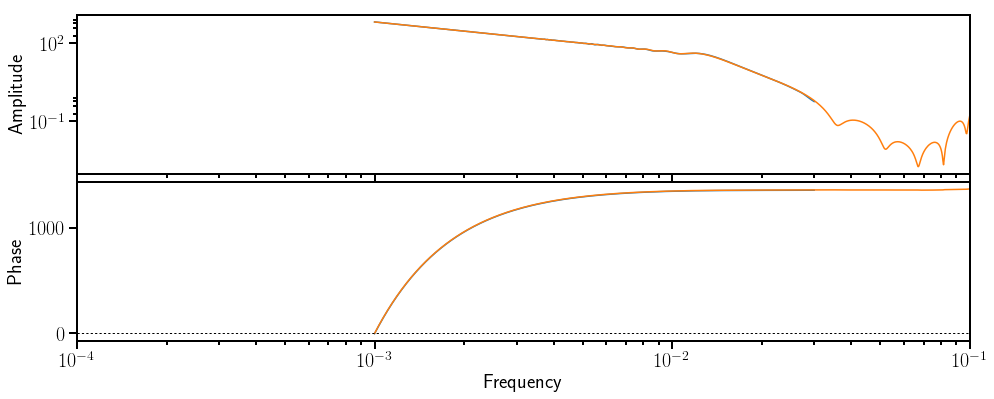

In [20]:
# Plot h_true and h_sur
#plt.subplots(2, figsize=(16, 6))
fig, (ax1, ax2) = wave.plot_waveforms_fd([hsur, hfshifted])
ax1.set_yscale('log')
ax2.axhline(0, ls=':', c='k', lw=1)
ax2.set_xlim(1.0e-4, 0.1)

print mf_to_f(1.0e-4, 2.0), mf_to_f(0.03, 2.0)
print mf_to_f(1.0e-4, 4.0), mf_to_f(0.03, 4.0)

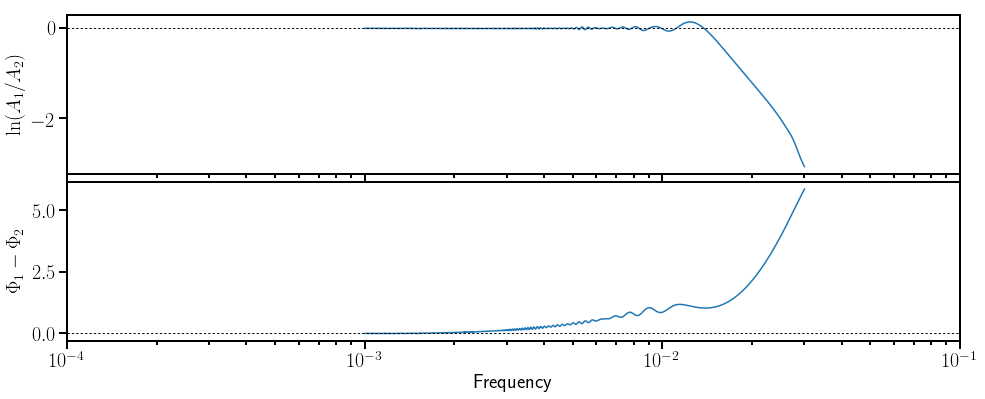

In [21]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([hdiffsur])
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax2.set_xlim(1.0e-4, 0.1)

ax1.set_ylabel(r'$\ln(A_1/A_2)$')
ax2.set_ylabel(r'$\Phi_1-\Phi_2$')

# Compare surrogate with TaylorF2 in physical units

In [35]:
mass1 = 3.0
mass2 = 1.4
spin1z = 0.0
spin2z = 0.0
lambda1 = 0.0
lambda2 = 0.0
delta_f = 1.0e-2
#f_min = 100.0
f_min = mf_to_f(0.001, mass1+mass2)
print f_min
f_max = 5000.0
distance = 100.0
inclination = 0.0

freq, hp, hc = surrogate_waveform_physical(Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list, 
                                mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, 
                                lambda1=lambda1, lambda2=lambda2,
                                delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=None, 
                                distance=distance, inclination=inclination, coa_phase=None)

freq_lal, hp_lal, hc_lal = lalsim_fd_waveform_arrays(mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, 
                                spin1x=0, spin1y=0, spin2x=0, spin2y=0, 
                                lambda1=lambda1, lambda2=lambda2, 
                                delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=None, 
                                distance=distance, inclination=inclination, coa_phase=None, 
                                approximant='TaylorF2')

46.1421462539


In [36]:
hpwave = wave.Waveform.from_hp_hc(freq, hp.real, hp.imag)
hplalwave = wave.Waveform.from_hp_hc(freq_lal, hp_lal.real, hp_lal.imag)

hcwave = wave.Waveform.from_hp_hc(freq, hc.real, hc.imag)
hclalwave = wave.Waveform.from_hp_hc(freq_lal, hc_lal.real, hc_lal.imag)

hpwave.x.shape, hplalwave.x.shape

((500000,), (500001,))

(10, 10000)

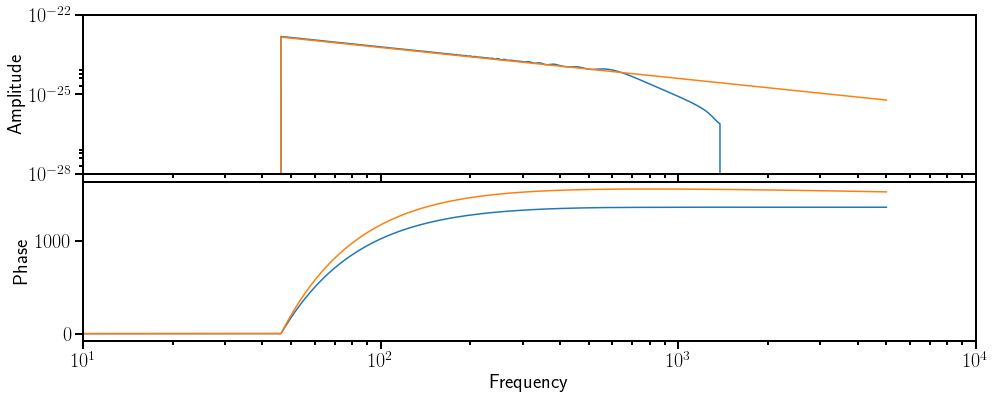

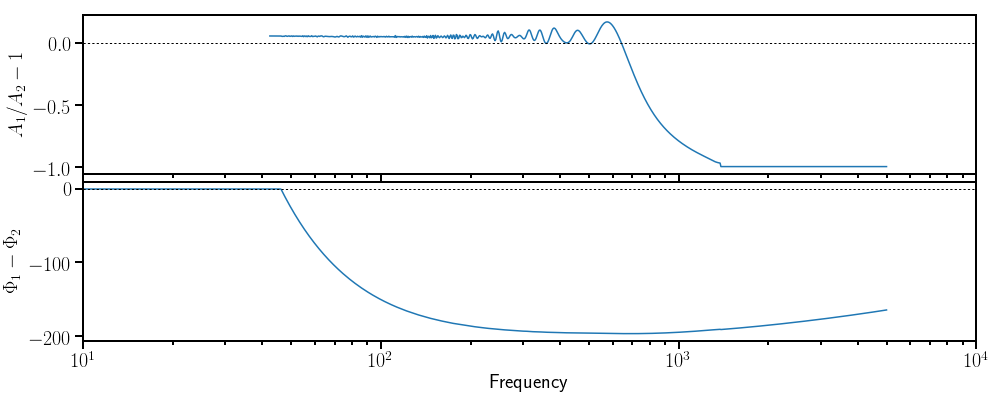

In [38]:
# Plot h_true and h_sur
fig, (ax1, ax2) = wave.plot_waveforms_fd([hpwave, hplalwave], xi=10)
ax1.set_yscale('log')
ax1.set_ylim(1.0e-28, 1.0e-22)
ax2.set_xlim(10, 10000)

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hpwave, hplalwave, xi=10.0)
ax2.set_xlim(10, 10000)

# Compare surrogate with SpinTaylorT4 in physical units

(100, 3000)

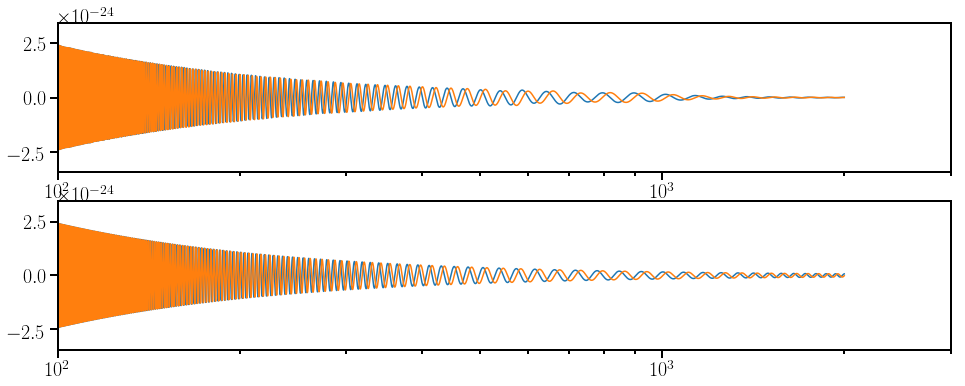

In [101]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
ax1.plot(freq, np.real(hp))
ax1.plot(freq, np.imag(hp))
ax1.set_xscale('log')

ax2.plot(freq_lal, np.real(hp_lal))
ax2.plot(freq_lal, np.imag(hp_lal))
ax2.set_xscale('log')

ax1.set_xlim(100, 3000)
ax2.set_xlim(100, 3000)

In [22]:
mass1 = 1.4
mass2 = 1.4
spin1z = 0.4
spin2z = 0.4 
lambda1 = 2000.0
lambda2 = 2000.0
delta_t = 1.0/2**12
f_min = 80.0
distance = 100.0
inclination = 1.2

hpT4, hcT4 = lalsim_waveform_time_series(approximant='SpinTaylorT4', 
                        mass1=mass1, mass2=mass2, 
                        spin1x=0, spin1y=0, spin1z=spin1z, 
                        spin2x=0, spin2y=0, spin2z=spin2z, 
                        lambda1=lambda1, lambda2=lambda2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_min=f_min, f_ref=f_min, 
                        amplitude_order=-1)

# hp1T4, hc1T4 = pycbc.waveform.get_td_waveform(approximant='SpinTaylorT4', 
#                         mass1=mass1, mass2=mass2, 
#                         spin1z=spin1z, spin2z=spin2z, 
#                         lambda1=lambda1, lambda2=lambda2, 
#                         distance=distance, inclination=inclination, 
#                         delta_t=delta_t, f_lower=f_lower, f_ref=f_lower, 
#                         amplitude_order=-1)

In [23]:
htildeT4 = hpT4.to_frequencyseries()
freqs = np.array(htildeT4.sample_frequencies)

In [24]:
hpwave.resample(freqs, order=2)

In [28]:
hcomp = hpwave.amp*np.exp(1.0j*hpwave.phase)

In [29]:
hsurFS = pycbc.types.FrequencySeries(hcomp, delta_f=freqs[1]-freqs[0])

In [33]:
hsurFS.delta_f, htildeT4.delta_f, len(hsurFS)

(0.24656874548519142, 0.24656874548519142, 8308)

In [35]:
mismatch(hsurFS, htildeT4, 100.0)

0.57041595436380854

(200, 300)

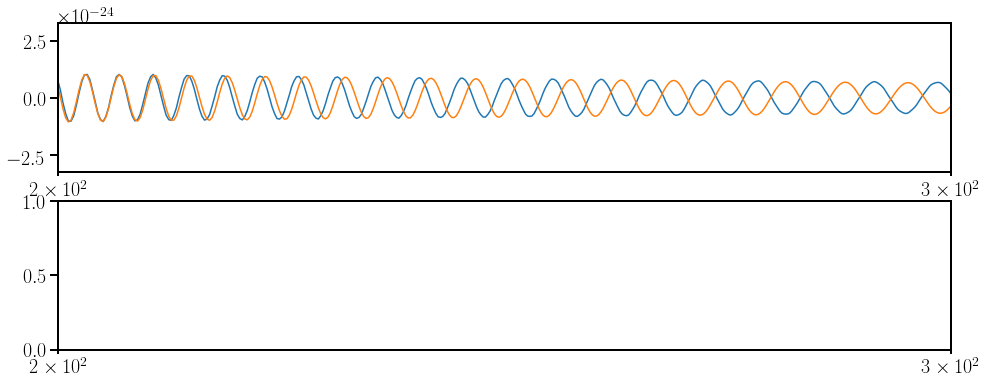

In [40]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
ax1.plot(htildeT4.sample_frequencies, np.real(htildeT4))
ax1.plot(hsurFS.sample_frequencies, np.real(hsurFS))
ax1.set_xscale('log')

# ax2.plot(freq_lal, np.real(hp_lal))
# ax2.plot(freq_lal, np.imag(hp_lal))
ax2.set_xscale('log')

ax1.set_xlim(200, 300)
ax2.set_xlim(200, 300)